In [17]:
# Data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# Graphing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

# Modelling
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# stats
import scipy

# Other
import joblib
from configparser import ConfigParser
import psycopg2

# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Purpose

For this classification task we will be constructing a model to contrast the crimes during daylight vs nighttime. We will only be focusing on data from Vancouver in 2018

## Load data

In [2]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='psql.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [3]:
# cfg = config('database.ini')

# # Establish connection with database and get cursor
# conn = psycopg2.connect(**cfg)
# cursor = conn.cursor()

# # Get all values from db
# get_all_query = 'select * from "CrimeDataMart".crime_fact as f'
# cursor.execute(get_all_query)
# result_list = cursor.fetchall()


In [4]:
# Load all tables and merge
data_path = '../data/dimensional_model/'
crime_dimension = pd.read_csv(data_path + 'crime_dimension.csv')
date_dimension = pd.read_csv(data_path + 'date_dimension.csv')
event_dimension = pd.read_csv(data_path + 'event_dimension.csv') 
location_dimension = pd.read_csv(data_path + 'location_dimension.csv')
crimes_fact = pd.read_csv(data_path + 'crimes_fact.csv')

all_crimes = crimes_fact.merge(crime_dimension, on = 'CRIME_PK', how = 'left')
all_crimes = all_crimes.merge(date_dimension, on = 'DATE_PK', how = 'left')
all_crimes = all_crimes.merge(location_dimension, on = 'LOCATION_PK', how = 'left')

# Filter for Vancouver 2018
all_crimes = all_crimes.query('CITY == "Vancouver" and YEAR == 2018')

In [5]:
all_crimes.head(5)

,IS_TRAFFIC,IS_FATAL,IS_NIGHTTIME,DATE_PK,CRIME_PK,LOCATION_PK,EVENT_PK,FIRST_OCCURRENCE_TIME,LAST_OCCURRENCE_TIME,REPORTED_TIME,OFFENSE_TYPE,OFFENSE_CATEGORY,IS_VIOLENT,FULL_DATE,DAY,MONTH,YEAR,DAY_OF_YEAR,WEEK_OF_YEAR,WEEKDAY,IS_WEEKEND,QUARTER,IS_MONTH_START,IS_MONTH_END,IS_YEAR_START,IS_YEAR_END,IS_CAN_HOLIDAY,CAN_HOLIDAY_NAME,IS_US_HOLIDAY,US_HOLIDAY_NAME,LOCATION,NEIGHBORHOOD,LATITUDE,LONGITUDE,CITY,CRIME_RATE
3,False,False,True,20180302,4,4,156,06:17:00,NaN,NaN,Burglary of a business with forced entry,Burglary,False,2018-03-02,2,3,2018,61,9,5,False,1,False,False,False,False,False,NaN,False,NaN,10XX ALBERNI ST,West End,49.284794,-123.122946,Vancouver,5485.315589
8,False,False,True,20180616,9,8,1,18:00:00,NaN,NaN,Burglary of a business with forced entry,Burglary,False,2018-06-16,16,6,2018,167,24,6,True,2,False,False,False,False,False,NaN,False,NaN,10XX ALBERNI ST,West End,49.284519,-123.122348,Vancouver,5485.315589
25,False,False,True,20181212,24,18,1,00:00:00,NaN,NaN,Burglary of a business with forced entry,Burglary,False,2018-12-12,12,12,2018,346,50,3,False,4,False,False,False,False,False,NaN,False,NaN,10XX BEACH AVE,West End,49.276572,-123.134358,Vancouver,5485.315589
33,False,False,True,20180409,28,22,1,06:00:00,NaN,NaN,Burglary of a business with forced entry,Burglary,False,2018-04-09,9,4,2018,99,15,1,False,2,False,False,False,False,False,NaN,False,NaN,10XX BEACH AVE,Central Business District,49.276180,-123.134055,Vancouver,5485.315589
41,False,False,False,20181002,38,26,1,18:31:00,NaN,NaN,Burglary of a business with forced entry,Burglary,False,2018-10-02,2,10,2018,275,40,2,False,4,False,False,False,False,False,NaN,False,NaN,10XX BEACH AVE,Central Business District,49.276070,-123.133924,Vancouver,5485.315589


In [6]:
cols_keep = ['IS_TRAFFIC', 'IS_FATAL', 'IS_NIGHTTIME', 'OFFENSE_CATEGORY', 'IS_VIOLENT', 'DAY', 'MONTH', 'WEEKDAY', 'IS_WEEKEND', 'QUARTER', 'IS_CAN_HOLIDAY']
all_crimes = all_crimes[cols_keep]

# Split data into train and test

X = all_crimes.drop('IS_NIGHTTIME', axis='columns')
Y = all_crimes['IS_NIGHTTIME'].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [7]:
# Preprocess columns

column_trans = ColumnTransformer([
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['OFFENSE_CATEGORY'])
], remainder='passthrough', sparse_threshold=0)

column_trans.fit(X_train)
X_train = column_trans.transform(X_train)
X_test = column_trans.transform(X_test)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0,
                  transformer_weights=None,
                  transformers=[('one_hot',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['OFFENSE_CATEGORY'])],
                  verbose=False)

1    0.551559
0    0.448441
Name: IS_NIGHTTIME, dtype: float64

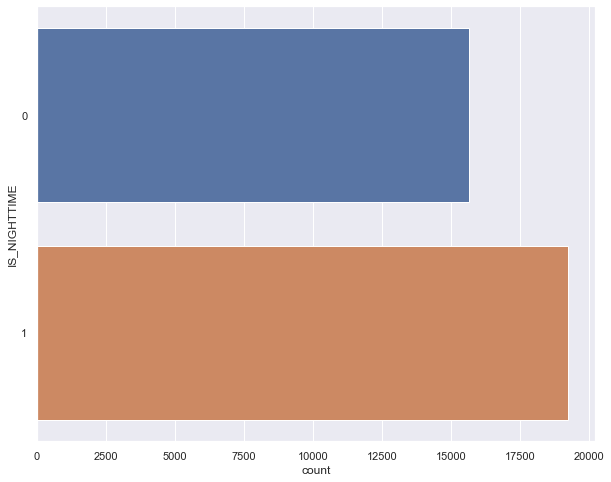

In [8]:
g = sns.countplot(y=Y)

Y.value_counts(normalize=True)

Not too imbalanced, so we will not apply any class imbalance methods

## Random Forest

In [9]:
rf_clf = RandomForestClassifier(n_jobs=-1)
cross_val_score(rf_clf, X_train, Y_train, scoring='f1')

array([0.75187707, 0.75128341, 0.74859353, 0.75387324, 0.74956278])

### Hyper parameter tuning

In [10]:
params_dist = {
    'n_estimators': np.arange(100, 1500, 100),
    'max_depth': [None, 2, 4, 7, 10 , 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10]
}

rf_random_search = RandomizedSearchCV(rf_clf, params_dist, cv=5, n_iter=50, scoring='f1', n_jobs=-1, verbose=1)
rf_random_search.fit(X_train, Y_train)

# Save results
joblib.dump(rf_random_search, 'random_forest_random_search.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

['random_forest_random_search.pkl']

In [11]:
rf_random_search.best_score_
rf_random_search.best_params_

0.7556650930559335

{'n_estimators': 1300,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 20}

## AdaBoost

In [12]:
ada_boost_clf = AdaBoostClassifier()
cross_val_score(ada_boost_clf, X_train, Y_train, scoring='f1')

array([0.72243346, 0.72292596, 0.72307415, 0.73412769, 0.71904417])

### Hyper parameter tuning

In [13]:
params_dist = {
    'n_estimators': np.arange(50, 1500, 50),
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

ada_boost_random_search = RandomizedSearchCV(ada_boost_clf, params_dist, cv=5, n_iter=20, scoring='f1', n_jobs=-1, verbose=1)
ada_boost_random_search.fit(X_train, Y_train)

# Save results
joblib.dump(rf_random_search, 'ada_boost_random_search.pkl')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1, 10],
                                        'n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
       

['ada_boost_random_search.pkl']

In [14]:
ada_boost_random_search.best_score_
ada_boost_random_search.best_params_

0.7274914416255484

{'n_estimators': 350, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

## Final scores

Overall, random forest performs better with lower cross-validated f1-score. However, we'll just plot both of their scores on the test set.

**Random Forest**

In [19]:
rf_pred = rf_random_search.best_estimator_.predict(X_test)
print(classification_report(Y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      3126
           1       0.84      0.68      0.75      3859

    accuracy                           0.75      6985
   macro avg       0.76      0.76      0.75      6985
weighted avg       0.77      0.75      0.75      6985



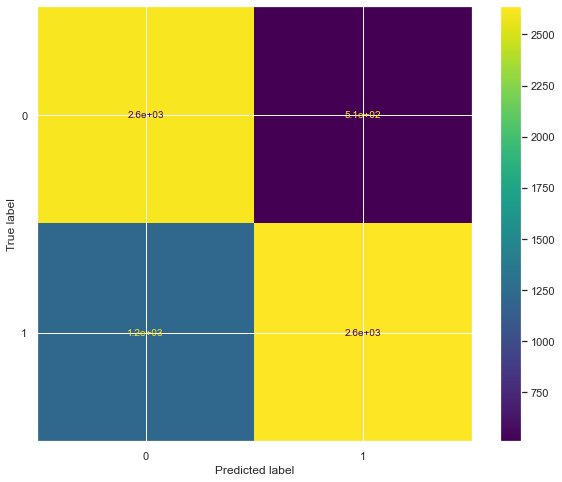

In [23]:
p = plot_confusion_matrix(rf_random_search.best_estimator_, X_test, Y_test)

**AdaBoost**

In [20]:
ada_boost_pred = ada_boost_random_search.best_estimator_.predict(X_test)
print(classification_report(Y_test, ada_boost_pred))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      3126
           1       0.81      0.68      0.74      3859

    accuracy                           0.73      6985
   macro avg       0.74      0.74      0.73      6985
weighted avg       0.75      0.73      0.73      6985



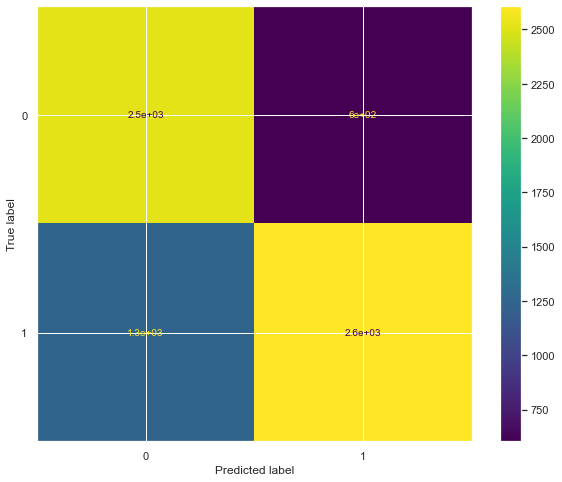

In [24]:
p = plot_confusion_matrix(ada_boost_random_search.best_estimator_, X_test, Y_test)

## Lessons learned

- understanding hyperparameters for random forest and ada boost
- learned how to do randomized searching with scikit learn
- cross-validation as method of estimating test error
